In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/fundus.zip

In [ ]:
# cataract_paths = './images/close-up/cataract/*'
# cataract_paths = glob(cataract_paths)
# cataract_paths = cataract_paths[:2000]

cataract_paths = '/content/fundus/cataract/*'
cataract_paths = glob(cataract_paths)
cataract_paths = cataract_paths
cataract_paths

In [7]:
# normal_paths = './images/close-up/normal/*'
# normal_paths = glob(normal_paths)
# normal_paths = normal_paths[:10000]

normal_paths = '/content/fundus/normal/*'
normal_paths = glob(normal_paths)
normal_paths = normal_paths

In [8]:
image_paths = normal_paths+cataract_paths

In [13]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [14]:
np.unique(labels)

array(['cataract', 'normal'], dtype='<U8')

In [15]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 2)))
pred2label = dict(zip(range(0, 2), np.unique(labels)))
n_classes = len(np.unique(labels))

In [16]:
class IrisDisease(torch.utils.data.Dataset):

    def __init__(self, image_paths, labels, transforms=None):
        super(IrisDisease, self).__init__()

        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))

        label = self.labels[idx]
        label = label2pred[label]
        label = torch.tensor(label)

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [17]:
device='cuda'

In [18]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.25, random_state=42)

In [19]:
tr_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(300),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [20]:
train_dataset = IrisDisease(image_paths=train_image_paths, labels=train_labels, transforms=tr_transforms)
test_dataset = IrisDisease(image_paths=test_image_paths, labels=test_labels, transforms=val_transforms)
# train_dataset = Dataset(image_paths=image_paths, label=labels, transforms=torchvision.transforms.ToTensor())

In [21]:
len(train_dataset)

15536

In [22]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

normal


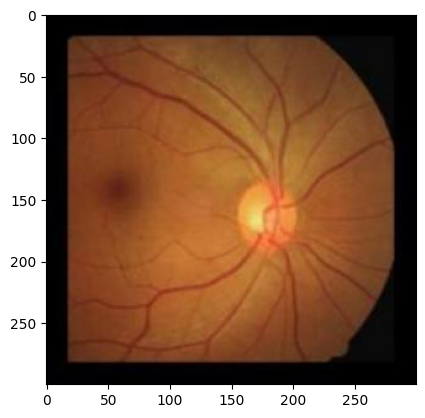

In [23]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[14][0].permute(1, 2, 0))
print(pred2label[train_dataset[14][1].item()])

In [24]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [25]:
class EfficientNetB3(ClassificationBase):

    def __init__(self):
        super().__init__()

        self.network = timm.create_model('efficientnet_b3', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)


    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))


model = EfficientNetB3()

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [26]:
model = torch.compile(model)

In [38]:
def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), 1e-6)
    for epoch in range(epochs):
        lrs = []
        loss = 0
        acc = 0
        for batch in tqdm.tqdm(train_loader):
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, loss, acc))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = model.to(device)

In [51]:
model.eval()
evaluate(model, test_dataloader)
# Model_1: 0.97

{'val_loss': 0.3796623945236206, 'val_acc': 0.9596836566925049}

In [46]:
import tqdm
model.train()
history = fit(5, model, train_dataloader, test_dataloader)

100%|██████████| 486/486 [04:38<00:00,  1.74it/s]


Epoch [0], loss: 0.4933, acc: 0.8750
Epoch [0], val_loss: 0.4721, val_acc: 0.9288


100%|██████████| 486/486 [04:38<00:00,  1.74it/s]


Epoch [1], loss: 0.3993, acc: 1.0000
Epoch [1], val_loss: 0.4290, val_acc: 0.9444


100%|██████████| 486/486 [04:38<00:00,  1.74it/s]


Epoch [2], loss: 0.5090, acc: 0.7500
Epoch [2], val_loss: 0.4059, val_acc: 0.9481


100%|██████████| 486/486 [04:38<00:00,  1.74it/s]


Epoch [3], loss: 0.3709, acc: 1.0000
Epoch [3], val_loss: 0.3918, val_acc: 0.9506


100%|██████████| 486/486 [04:38<00:00,  1.74it/s]


Epoch [4], loss: 0.3943, acc: 0.9375
Epoch [4], val_loss: 0.3821, val_acc: 0.9545


In [47]:
torch.save(model.state_dict(), 'model_2.pth')

In [48]:
losses = []
accs = []
for i in range(len(history)):
  losses.append(history[i]['val_loss'])
  accs.append(history[i]['val_acc'])

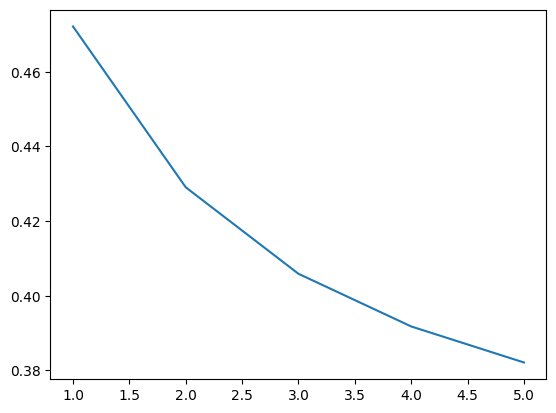

In [49]:
plt.plot(np.linspace(1, 5, 5).astype(int), losses)

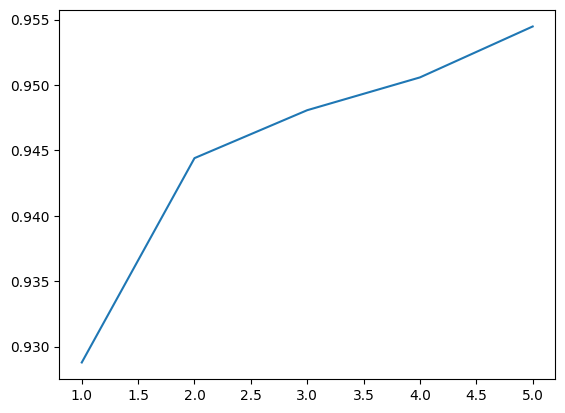

In [50]:
plt.plot(np.linspace(1, 5, 5).astype(int), accs)

In [ ]:
model.load_state_dict(torch.load('model_1.pth', map_location=torch.device('cuda')))
model